# Convolutional Neural Networks (CNN)

> __Created__: Fall 2021, LPC Statistics Course 2021, Harrison B. Prosper<br>
> __Updated__: Mar. 20, 2023, CLASHEP 2023, San Esteban, Chile<br>
 > __Updated__: June 28, 2023 for Terascale 2023, DESY, Hamburg, Germany
 
 
## Task
Use a convolutional neural network (CNN) to classify the handwritten digits in the MNIST data set. 

## Introduction
In this notebook, we use a convolutional neural network (CNN) to classify the handwritten digits in the MNIST data set. Each image is represented by a $(28, 28)$ matrix, with matrix element values in the set $[0, 1/255, \cdots, 1]$. In practice, a __batch__ of images is stored in a 4-index tensor $\mathbf{x}_{ncij}$ of __shape__ $(n, C, H, W)$. Think of this as a 4-dimensional array each cell of which contains a pixel value. The first index (dim = 0) labels the ordinal value (position) of an image in a batch of $n \ll N$ images, where $N$ is size of the training sample; the second index (dim = 1) labels the number of __channels__, $C$, that is, image planes, which for a gray scale image is $C = 1$, and would be $C = 3$ for a red, green, blue (RGB) image, while the last two indices (dim = 2, 3) label the pixels of an image of height and width $H$ and $W$, respectively. 

### Model

A typical convolutional neural network (CNN) comprises an alternating sequence of convolutional and coarse-graining (or __down-sampling__) layers ending with a fully connected feedforward neural network or a CNN. A convolutional layer cross-correlates its inputs with a kernel, while (typically) increasing the number of output channels. The coarse-graining layer takes in one or more planes of images, that is, channels, and creates output images of smaller size. Here is a high-level view of the model we shall fit,

\begin{align*}
\mathbf{y} & = \mbox{softmax}(\mathbf{b}_2 + {\rm fn} (\mathbf{w}_2, \mathbf{b}_1 + {\rm cc}(\mathbf{w}_1, \, \mathbf{b}_0 + {\rm cc}(\mathbf{w}_0, \, \mathbf{x}) \, ) \,)\,),
\end{align*}

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model and the functions __softmax__, __fn__, and __cc__ are defined as follows:

  * __softmax__ For $K$ output classes, 
\begin{align*}
\mbox{softmax}(x_k) & = \frac{\exp(x_{k})}{\sum_{j=1}^{K} \exp(x_{j})} ,
\end{align*}
where $x_{k}$ denotes the $k^\mbox{th}$ output of the previous layer. The
softmax function
is used to bound the output values to the unit interval and ensure that 
their sum is unity. 

  * __fn__ Given tensors $\mathbf{w}$ and $\mathbf{x}$, this function operates *element-wise* on its inputs and returns 
  
  $$\text{fn}(\mathbf{w}, \mathbf{x}) = \mathbf{w} \, \text{flatten}(\, \text{relu}(\,\text{maxpool}(\,\mathbf{x}\,)\,)\,).$$


  * __cc__ Given tensors $\mathbf{w}$ and $\mathbf{x}$, this function returns their cross-correlation.

    $$\mathbf{x}_{kij} = \sum_{c=1}^{C} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{c,\, i+r,\,j+s} \, \mathbf{w}_{kcrs} .$$

  * __flatten__ Given tensor $\mathbf{x}$, this function restructures $\mathbf{x}$ into a 1D tensor (a 1D array).

  * __relu__ Given tensor $\mathbf{x}$, the function 
\begin{align*}
{\rm relu}(x) &= \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}
is applied
*element-wise*, that is, to every element of the tensor.

  * __maxpool__ Given tensor $\mathbf{x}$, this function uses a moveable window to apply a coarse-graining operation over $\mathbf{x}$. In effect, the moveable window  splits the tensor into non-overlapping pieces. Then, for each piece, the maximum value within that piece is returned. For example, if $\mathbf{x}$ is a 2D tensor, e.g., a matrix, of shape (28, 28), and the window is of shape (2, 2), maxpool splits the original matrix into non-overlapping pieces of shape (2,2) and returns the maximum value within each piece, thereby creating a new matrix of shape (14, 14).



A high-level view is a good way to represent the structure of a model.  But, it is also good to try to understand the details...at least once. As is often true, a detailed mathematical description of a complicated function is made easier using an example. 

#### Convolutional layer
The data into the first convolutional layer are a sequence of single channel (gray scale) images $\mathbf{x}$ of shape $(n, C, H, W)=(n, 1, 28, 28)$, that is, the data  form a tensor comprising $n$ images, each with a single channel ($C = 1)$, and each a $(28, 28)$ matrix of pixels. This tensor is cross-correlated with a 4D tensor of weights $\mathbf{w}_0$, with shape $(4, 1, 5, 5)$. We shall refer to the latter as a __kernel__ and each of its $4 \times 1$ $(5, 5)$ matrices (or 2D tensors) as a __filter__. The first index of the kernel is the number of __output channels__ (here, 4), the second is the number of __input channels__ (here, 1). Therefore, a given $(5, 5)$ filter is identified by two indices: its output and input channel numbers. The last two indices of the kernel are the height (5) and width (5), respectively, of its filters. 

(Unfortunately, the jargon is not consistent across the machine learning literature. What we call a filter is indeed often referred to as a filter, but it is also called a kernel, and what we call a kernel, that is, a stack of one or more filters, often has no specific name attached to it!) 

The operation of the convolutional layer for filters with odd-numbered height and width, e.g. $(5, 5)$, can be written as

\begin{align}
    (\mathbf{b}_0)_k + (\mathbf{w}_0 \otimes \mathbf{x})_{nkij} &= (\mathbf{b}_0)_k + \sum_{c=0}^{C-1} \sum_{r=-2}^2 \sum_{s=-2}^2  \mathbf{x}_{nc,\, i+r,\,j+s} \, (\mathbf{w}_0)_{kcrs}, \quad i, j = 0,\cdots, 27 ,
\end{align}

where, we have chosen to label the central matrix element of a filter with the indices $(0, 0)$ and the other elements with indices that can be positive or negative integers. In the above expression, for a given pixel $i, j$, the filter labeled $k, c$, namely the matrix $(\mathbf{w}_0)_{kc}$ with matrix elements $(\mathbf{w}_0)_{kcrs}$, is cross-correlated with channel $c$ of input image $n$ and a sum over the cross-correlated input channels, that is, over the index $c$, is performed, resulting in $k$ output images.

However, for the above computations to work as shown, we need (in effect) to surround each image with extra strips of pixels. This operation is called __padding__. In the following, we choose to pad each image with 2 strips of pixels, with value zero. This padding makes it possible to center the $(5, 5)$ filters on every pixel, $i, j$, within the image. Had we used, for example, $(3, 5)$ filters, the appropriate padding shape would be $(1, 2)$, that is, 1 extra strip of pixels along the top and bottom of the image and 2 extra strips along the left and right sides of the image. We are free to make other choices.

Since the input image is a $(28, 28)$ matrix padded with 2 strips of pixels around the boundary, and each filter is a $(5, 5)$ matrix,
the output of the convolution step will be a tensor of shape $(n, 4, 28, 28)$ provided that we use a __stride__ of 1, that is, if during the cross-correlation, we shift the filters a horizontal or vertical step of 1 pixel. Other choices are possible. By
construction, the output of this convolutional layer is $n$, 4-channel images, of the same size, that is, $(H, W) = (28, 28)$, as the original, by choice.

#### Coarse-graining layer
A convolutional layer is usually followed by a coarse-graining, that is, down-sampling, layer that reduces the number of pixels per image. In this example, the number of pixels in the image created by the convolutional layer is reduced by a factor 2 in both directions; that is, each of the 4 channels of the $(28, 28)$ image is down-sampled into a $(14, 14)$ channel by replacing the corresponding group of pixels of shape $(2, 2)$ with a pixel whose value is set to the largest value among the group of 4 pixels.  This operation, called __max-pooling__, can be expressed as

\begin{align}
    {\rm maxpool}(O)_{nkij} &= \max{ \{O_{nk,\, 2i + r,\, 2j + s} \}_{r,\,s = 0, 1} } \quad i, j = 0,\cdots, 13,
\end{align}

where $O$ is the output of a convolutional layer. Again, other choices are possible.

After max-pooling, the output tensor has shape $(n, 4, 14, 14)$. A relu __activation function__ is applied to each element of this tensor in order to complete one sequence of operations: cross-correlation, down-sampling, and activation. 

A second convolutional layer follows. This time, however, its input must match the output of the previous max-pooling operation, which contains $n$ sequences of images, each with 4 channels, and each a $(14, \, 14)$ matrix padded with a 2-pixel boundary. The kernel in this layer contains $16 \times 4$ $(5, 5)$-filters, that is, it is of shape $(16, 4, 5, 5)$. Each of the 64 $(5, 5)$-filters is cross-correlated with the corresponding input channel. The cross-correlated input channels are then summed pixel by pixel to yield  a 16-channel output image from this layer. In other words, we arrive at an output tensor of size $(n, 16, 14, 14)$.

Finally, a second max-pooling layer is applied, which transforms the 16-channel image of shape $(14, 14)$ to a 16-channel image of shape $(7, 7)$. The image is then flattened into a 1D tensor (basically, a 1D array) of size $16 \times 7 \times 7 = 784$, which are the inputs of the final linear layer with 10 outputs. Finally, a softmax function is applied to the 10 outputs of the final linear layer so that the 10 outputs of the CNN sum to one. This makes sense because the outputs are estimates of the __class probabilities__, that is, the probabilities that an input image belongs to any one of the ten digit classes. 

The class with the largest probability among the 10 probabilities is taken as the class to which the input image belongs. This decision strategy is an example of a __greedy policy__: we always go for the best choice. However, the best choice is not necessarily always the best strategy. If we could quantify the confidence level of each of the ten probabilities, it may happen that we decide to choose the next highest probability if the confidence level associated with it was higher than that associated with the largest probability.


### Discussion
The net effect of the sequence of nested layers, prior to flattening, is to transform an input image, comsisting of one or more channels, into a multi-channel output image. The hope is that the multi-channel output image captures the most relevant features of the input image thereby improving the accuracy of the subsequent classification. 

But, why use cross-correlation?

The intuition behind the cross-correlation operation is that natural images tend to have similar features in different parts of the image. A filter that is sensitive to vertical features would tend to produce an output image that enhances vertical features, while suppressing the expression of horizontal features. It therefore seems plausible that if one could design filters that are sensitive to different image features, the set of filters could potentially transform an image into another in which the most relevant features are enhanced while the least relevant are suppressed. 

In the early days of image recognition systems, researchers tried to describe in software what they considered to be the most relevant features in images. This proved to be extremely difficult and success was limited. Today hand-coding is no longer necessary because the values of the parameters of the kernels can be determined automatically by minimizing an appropriate (average) loss function. However, the mere fact that a large number of images is needed to fit these parameters is evidence that current machine learning methods and models, while spectacularly successful, are still far removed from human learning methods and models. 

A young child need be shown labeled objects, cat, dog, doll, truck, car, just a few times before being able to classify them correctly. The child can do this even when the objects are presented to her or him in orientations that differ from the ones used during the "training phase". This extraordinary ability suggests that the child's brain constructs a fault tolerant model of each object using only its most relevant features and is able to match rapidly the input image with the stored, or more likely the auto-reconstructed, fault tolerant model. The model is clearly fault tolerant because the child is able to ignore "faults" such as viewing the objects in lighting that differs from that used during the "training phase", or ignoring the fact that now the car has lost a couple of wheels or the doll is now wearing different clothes and so on. 

In spite of the truly impressive recent successes, it is clear that machine learning-based artificial intelligence (AI) still has a long way to go. Of course, it could be that the age-old goal of building machines that think like humans is simply the wrong goal. After all, there are already many instances in which researchers have inadvertently succeeded in producing machines that mimic our prejudices, which is hardly progress. Therefore, perhaps we should embrace the "artificial" in AI and the possibility that these machines will inevitably "think" differently from us. The trick, of course, is to have them "think" in a way that improves the human condition. It would not be helpful if, for example, our super-intelligent machine concluded that the best way to solve climate change is to eliminate one of its culprits, namely, the species Homo sapiens!

In [1]:
import os, sys
import pandas as pd
import numpy as np
import random as rd

import matplotlib as mp
import matplotlib.pyplot as plt

import imageio as im
import torch
import torch.nn as nn
import torch.nn.functional as F

#  a function to save results
import joblib as jb

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 128
rnd  = np.random.RandomState(seed)

### Check available device (GPU or CPU)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


## Load MNIST data

Load MNIST data and show a few images from the training set.

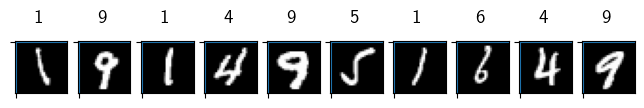

In [4]:
train_x = jb.load('../data/mnist_train_x.gz')
train_t = jb.load('../data/mnist_train_t.gz')

test_x  = jb.load('../data/mnist_test_x.gz')
test_t  = jb.load('../data/mnist_test_t.gz')

# now let's show some randomly chosen images from the traininng set.
count = 0
size  = 10
plt.figure(figsize=(8, 5))

for i in np.random.permutation(train_x.shape[0])[:size]:
    count = count + 1
    plt.subplot(1, size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=train_t[i], fontsize=FONTSIZE)
    plt.imshow(train_x[i].reshape(28, 28), cmap="gray")
    plt.savefig('mnist_images.png')
    
plt.show()

### Plot a few  images in more detail
Use imshow(..) and show() to display the image.

In [5]:
def plotImages(x, n_rows=2, n_cols=2, f_size=(5, 5)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    d = np.arange(0.5, 28.05, 1)
    for image, ax in zip(x, ax.flatten()):
        #ax.axis('off')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        ax.imshow(image.reshape(28, 28), cmap='gray')

        ax.set_xticks(d, minor=False)
        ax.set_yticks(d, minor=False)
        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')

    plt.savefig('mnist_images.png')
    plt.show()

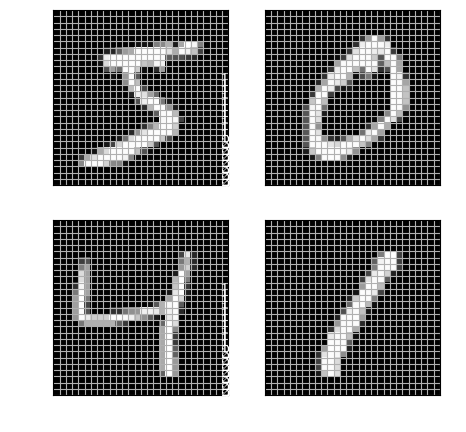

In [6]:
plotImages(train_x)

### Prepare training and validation sets

Convert to PyTorch tensors.

In [7]:
train_fraction = 5/6        # fraction of data used for training

M = int(train_fraction*len(train_x))
train_x, valid_x = train_x[:M], train_x[M:]
train_t, valid_t = train_t[:M], train_t[M:]

n_train   = len(train_x)
n_valid   = len(valid_x)
n_test    = len(test_x)
n_valid_b = 5000

def dataframe2tensor(x, t):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(x).float().to(device)
    t = torch.tensor(t).int().to(device)
    return x, t

train_x, train_t = dataframe2tensor(train_x, train_t)
valid_x, valid_t = dataframe2tensor(valid_x, valid_t)
test_x,  test_t  = dataframe2tensor(test_x,  test_t)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("validation batch size:           %10d" % n_valid_b)
print("number of images for testing:    %10d" % n_test)

number of images for training:        50000
number of images for validation:      10000
validation batch size:                 5000
number of images for testing:         10000


### Define model

#### Layer normalization

We shall use layer normalization to ensure that inputs into every layer of the machine learning (ML) model are approximately bounded and of order unity. (See https://arxiv.org/abs/1607.06450).

$
\begin{align}
    y \leftarrow \frac{y - \text{E}(y)}{\sqrt{\text{Var}(y) + \epsilon}}
\end{align}
$

Here is a simple example of the use of LayerNorm.

In [8]:
# Create a 4D tensor of shape (2,2,3,3) filled with random numbers
x = torch.randn(2, 2, 3, 3)
z = torch.zeros(2, 2, 3, 3)

print('\noriginal tensor: shape %s\n' % str(x.shape))
print(x)


print('\ncompute normalized tensor "by hand"')
m = torch.mean(x[0])
v = torch.var(x[0], unbiased=False)
z[0] = (x[0] - m)/np.sqrt(v)

m = torch.mean(x[1])
v = torch.var(x[1], unbiased=False)
z[1] = (x[1] - m)/np.sqrt(v)

print('normalized tensor')
print(z)

# with no learning parameters
print('\ncompute normalized tensor with LayerNorm')
nm = nn.LayerNorm(x.shape[1:], elementwise_affine=False)
y  = nm(x) 
print('normalized tensor')
print(y)


original tensor: shape torch.Size([2, 2, 3, 3])

tensor([[[[ 1.9215, -0.4985,  0.3597],
          [-0.4715,  1.1706, -1.5145],
          [ 0.0788, -0.5680,  1.4927]],

         [[-0.1638, -0.5203, -0.0574],
          [ 0.6221, -0.6837, -0.9427],
          [-0.1640, -0.9198, -1.3169]]],


        [[[ 0.4799,  0.0393, -0.1273],
          [ 0.1492, -0.6274, -1.2355],
          [ 0.0071,  0.4538, -0.4235]],

         [[-0.8886, -0.7429,  0.8008],
          [ 0.9361, -1.1059, -1.4886],
          [-0.1002,  0.0660,  1.6630]]]])

compute normalized tensor "by hand"
normalized tensor
tensor([[[[ 2.2447, -0.4150,  0.5282],
          [-0.3853,  1.4193, -1.5317],
          [ 0.2195, -0.4914,  1.7735]],

         [[-0.0472, -0.4389,  0.0698],
          [ 0.8166, -0.6186, -0.9032],
          [-0.0474, -0.8781, -1.3145]]],


        [[[ 0.7528,  0.1992, -0.0102],
          [ 0.3373, -0.6387, -1.4029],
          [ 0.1586,  0.7200, -0.3825]],

         [[-0.9669, -0.7838,  1.1560],
          [ 1.3261

Use some notebook magic to write the following cell to a file, which can then be imported into another notebook. 

In [20]:
%%writefile MNIST_CNN.py

import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
    def __init__(self):

        """
    A convolutional + fully-connected linear network.
        """ 
        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()
        
        # Since we are using 5x5 filters, adding zero padding of 2 
        # around each image will allow cross-correlation of every 
        # pixel in the image with the filters. Also, every filter 
        # will be centered on each pixel as the filters are moved
        # around the image. Since every pixel is processed, we obtain 
        # output images, that is, channels that are the same size as 
        # the input images.
        self.conv0 = nn.Conv2d(in_channels=1,    # input channels
                               out_channels=4,   # output channels
                               kernel_size=5,    # filter size (5x5)
                               stride=1,         # shift by this amount     
                               padding=2)        # pad by this amount
        
        self.conv1 = nn.Conv2d(in_channels=4,    # input channels
                               out_channels=16,  # output channels
                               kernel_size=5,
                               stride=1,
                               padding=2)
        
        # We end with a linear layer. Let's compute the number of
        # inputs to that layer. Ignoring the first index of the output
        # tensor from conv1, which simply labels the ordinal value of 
        # the image in the batch of images, we note the following:
        # 1. conv0 outputs a tensor of size (4, 28, 28), that is, it
        #    outputs 4 image planes, each of shape (28, 28).
        #    We then down-sample to a tensor of size (4, 14, 14).
        #
        # 2. conv1 outputs a tensor of size (16, 14, 14), which will be
        #    down-sampled to one of size (16, 7, 7).
        #
        # 3. Therefore, when flattened, the number of inputs to the
        #    linear layer is: 16 * 7 * 7 = 784
        self.n_inputs = 16 * 7 * 7
        
        # 4. We have 10 outputs, one for each digit
        self.linear0 = nn.Linear(self.n_inputs, 10)
    
    # define (required) method to compute output of network
    def forward(self, x):
        # conv0 expects a 4-d tensor of shape 
        # (batch_size, channels, width, height). So we must reshape x. 
        # Note: -1 means the number of instances in the batch of 
        # images is inferred at runtime from x.
        y = x.view(-1, 1, 28, 28)
        
        # 1. cross-correlate the input tensor of shape (-1, 1, 28, 28),
        #    padded with a 2-pixel wide strip, with a (4, 1, 5, 5) 
        #    kernel, thereby producing an output tensor of shape 
        #    (-1, 4, 28, 28).
        y = self.conv0(y)
        
        # 2. normalize images (over all channels and pixels, but not
        #    the batch).
        y = F.layer_norm(y, y.shape[1:])
        
        # 3. down-sample with a (2,2) window, which shifts horizontally
        #    and vertically 2 pixels at a time. This replaces the 4
        #    (28, 28) channels by 4 (14, 14) channels, by replacing a 
        #    group of 2x2 pixels in an input channel with a single
        #    pixel. The output tensor at this stage has shape 
        #    (-1, 4, 14, 14).
        y = F.max_pool2d(y, 2)
        
        # 4. apply a relu non-linearity to every element of this tensor;
        # that is, apply the relu element-wise
        y = F.relu(y)
        
        # 1. cross-correlate a (-1, 4, 14, 14) tensor, padded as above, 
        #    with a (16, 4, 5, 5) kernel and, for each (5, 5) filter, 
        #    sum over the 4 input channels. Since the kernel contains 
        #    16 output channels, the end result is a 16-channel image. 
        #    The output therefore has shape (-1, 16, 14, 14).
        y = self.conv1(y) 
        
        # 2. normalize the images.
        # 3. down-sample with a (2,2) window, as above, thereby 
        #    creating an output tensor of shape (-1, 16, 7, 7).
        # 4. apply a relu function element-wise (as above).
              
        #y = F.layer_norm(y, y.shape[1:])
        y = F.max_pool2d(y, 2)
        y = F.relu(y)
       
        # flatten the tensor (-1, 16, 7, 7) to the tensor (-1, 16*7*7).
        y = y.view(-1, self.n_inputs)
        
        # During training, randomly dropout, that is, zero, 
        # half of the elements in the current tensor y. dropout has
        # been shown to improve the training and yield better results.
        # Dropout effectively deactivates all the weights attached 
        # to the zeroed element. Alternatively, it can be thought of as a
        # way to apply random modifications to a multi-channel image by
        # randomly setting half the pixels to zero at each iteration.
        y = F.dropout(y, p=0.5, training=self.training)
    
        # Apply a linear transformation to the (-1, 784) tensor.
        y = self.linear0(y)
        
        # Apply the softmax function horizontally, i.e., along 
        # the class axis (dim=1) in order to ensure that the outputs 
        # sum to unity.
        # (Note: dim=0 is vertical, that is, along the batch axis.)
        
        # Final output: estimated class probabilities for ith image,
        #   q_i(k) = exp(y_i(k) / sum_j exp(y_i(j)), j = 0,..., K-1,
        # where K=10 is the number of classes and y_i(k) is the output 
        # for the ith feature vector for class index k. 
        
        y = F.softmax(y, dim=1)

        return y

Overwriting MNIST_CNN.py


### Define loss function

In [21]:
class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
        outputs:  shape (batch_size, number_classes), pre-softmax outputs
        targets:  shape (batch_size, ), class indices [0,...,C-1] 
        """        
        # ---------------------------------------------------------------       
        # The cross entropy is defined by
        #   H(p, q) = -sum_i p_i log(q_i)
        #
        # The entropy is defined by
        #   H(p)    = -sum_i p_i log(p_i)
        #
        # and the Kullback-Leibler divergence by
        #   D(p||q) = -sum_i p_i log(p_i/q_i)
        #           = -sum_i p_i log(p_i) + sum_i p_i log(q_i)
        #           = H(p) - H(p, q)
        #
        # Therefore, the cross entropy is minimized when the estimated 
        # probabilities q_i match the true probabilities p_i, in which 
        # case the cross entropy equals the entropy.
        # --------------------------------------------------------------- 
        
        # Note the numpy-like syntax for accessing elements of the
        # tensor: outputs[list1, list2] 
        # Note also: range(batch_size) is [0,...batch_size-1]
        #
        # outputs is a (-1, 10) tensor. For each image pick the output 
        # value corresponding to its class. Recall that targets is 
        # a 1D tensor (basically, a 1D array) of class labels. 
        # For every row, we pick the value in the column corresponding
        # to the class label.
        batch_size = len(outputs)
        outputs    = outputs[range(batch_size), targets]
        return -torch.mean(torch.log(outputs))

In [22]:
avloss = AverageLoss()

### Get batch
Get a random sample from the training set of size $batch\_size$

In [24]:
def randomBatch(x, t, batch_size):
    rows = torch.randint(0, len(x)-1, (batch_size,))
    return x[rows], t[rows]

### Accuracy
Fraction of correct predictions

In [25]:
def accuracy(outputs, targets):
    # For each image, return its predicted class label using argmax.
    #
    # argmax scans the numpy along the specified axis, here the 
    # horizontal axis, which is in the class direction, and returns the
    # ordinal value of the maximum value, that is, the predicted class. 
    # Note: outputs must be converted from a tensor to a numpy array 
    # before being passed to argmax. axis=1 is to numpy what dim=1 is
    # to PyTorch.
    outputs = np.argmax(outputs.data.numpy(), axis=1)
    
    # count how often the predicted class matches the actual class and
    # compute the fraction of correct predictions. 
    # Note: targets must be converted to a numpy array for the 
    # comparison to work since outputs is a numpy array.
    return float(np.mean(outputs==targets.data.numpy()))

### Trainer

In [37]:
def train(model, optimizer, loss_fn, train_x, train_t, batch_size):
    
    model.train() # training mode
    
    # get a random sequence of training data
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        x, t = randomBatch(train_x, train_t, batch_size)       
    
    # compute output of model
    y    = model(x)
    
    # compute loss functions, given the model outputs and the targets
    loss = loss_fn(y, t) 
    
    optimizer.zero_grad()  # clear previous gradients
    
    loss.backward()        # compute gradients
    
    optimizer.step()       # move one step
        
def validate(model, train_x, train_t, valid_x, valid_t):
    
    model.eval() # evaluation mode
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, y
        
        # to speed things up, use a random subset of n_valid_b images.
        x, t  = randomBatch(train_x, train_t, n_valid_b)       
        y     = model(x)
        acc_t = accuracy(y, t)
          
        x, t  = randomBatch(valid_x, valid_t, n_valid_b)        
        y     = model(x)
        acc_v = accuracy(y, t)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, loss_fn, traces,
               train_x, train_t,
               valid_x, valid_t,
               n_iterations, batch_size, 
               step=100):
    
    xx, yy_t, yy_v = traces
    if len(xx) == 0:
        xxstart = 0
    else:
        xxstart = xx[-1]
   
    for ii in range(n_iterations):
        
        train(model, optimizer, loss_fn, train_x, train_t, batch_size)

        if ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    valid_x, valid_t)
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')
        
            xx.append(xxstart+ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()
    return xx, yy_t, yy_v

### Create an instance of the model and choose minimizer

In [38]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [39]:
import MNIST_CNN as cnn
importlib.reload(cnn)
model = cnn.Model().to(device)
print(model)
print(f'number of parameters: {number_of_parameters(model):d}')

Model(
  (conv0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (linear0): Linear(in_features=784, out_features=10, bias=True)
)
number of parameters: 9570


### Train and validate

In [45]:
def plot(traces):

    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # axis limits
    ax.set_ylim((0.9, 1))
    ax.set_xlim((0, xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')
    
    ax.set_title('Training and Validation Accuracy', fontsize=16)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.grid(True, which="both", linestyle='-')
    
    ax.legend(loc='lower right')
    
    plt.savefig('fig_mnist_accuracy.png')
    plt.show()

In [41]:
traces   = [[], [], []]

In [42]:
n_iter   = 50000    # number of iterations
n_batch  =   128    # number of images/training batch
learning_rate = 1.e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
traces = trainModel(model, optimizer, avloss, traces,
                            train_x, train_t, 
                            valid_x, valid_t,
                            n_iter,  n_batch, 
                            step=100)
print("\ndone!")
plot(traces)

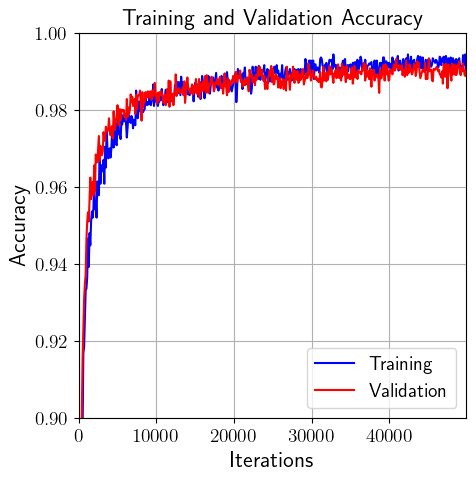

### Save model state

In [33]:
print("model details")
print('number of model parameters: %d\n' % number_of_parameters(model))
for key in model.state_dict():
    print('  %-16s\t%s' % (key, model.state_dict()[key].size()))
torch.save(model.state_dict(), 'mnist_cnn.pth')

model details
number of model parameters: 9570

  conv0.weight    	torch.Size([4, 1, 5, 5])
  conv0.bias      	torch.Size([4])
  conv1.weight    	torch.Size([16, 4, 5, 5])
  conv1.bias      	torch.Size([16])
  linear0.weight  	torch.Size([10, 784])
  linear0.bias    	torch.Size([10])


### Compute accuracy on test data

In [49]:
model.eval()
y = model(test_x)
acc = accuracy(y, test_t)
print(f'Accuracy on test data: {acc:6.3f}')

Accuracy on test data:  0.990
